# Regression Trees and Model Optimization - Lab

[Original source in the curriculum](https://github.com/learn-co-curriculum/dsc-tuning-regression-trees-lab)

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from scipy import stats

In [5]:
# Load the Ames housing dataset 
data = pd.read_csv('data/ames.csv')

# Print the dimensions of data
print(data.shape)

# Check out the info for the dataframe
print(data.info())

# Show the first 5 rows
data.head()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [6]:
# Features and target data
used_cols = ['LotArea', '1stFlrSF', 'GrLivArea']
features = data[used_cols]

target = data['SalePrice']

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LotArea    1460 non-null   int64
 1   1stFlrSF   1460 non-null   int64
 2   GrLivArea  1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

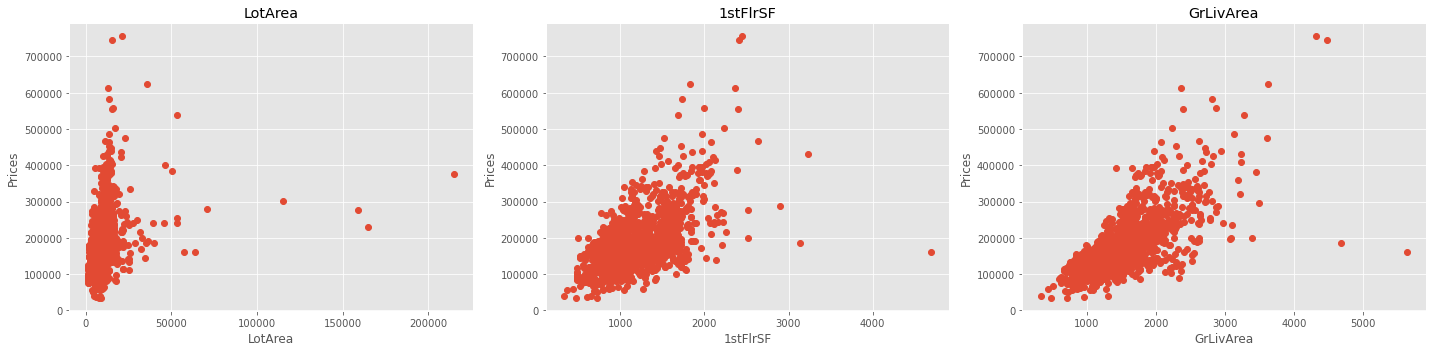

In [8]:
# Your code here 
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], target, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Prices')
    plt.tight_layout()

## Removing Outliers

Will only allow our app to insert specific numbers, so going to reflect these numbers in our training data

In [9]:
# Features and target data
df_comb = features.copy()
df_comb['target'] = target

In [10]:
df_comb.head()

,LotArea,1stFlrSF,GrLivArea,target
0,8450,856,1710,208500
1,9600,1262,1262,181500
2,11250,920,1786,223500
3,9550,961,1717,140000
4,14260,1145,2198,250000


In [11]:
df_comb.describe()

,LotArea,1stFlrSF,GrLivArea,target
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,1162.626712,1515.463699,180921.195890
std,9981.264932,386.587738,525.480383,79442.502883
min,1300.000000,334.000000,334.000000,34900.000000
25%,7553.500000,882.000000,1129.500000,129975.000000
50%,9478.500000,1087.000000,1464.000000,163000.000000
75%,11601.500000,1391.250000,1776.750000,214000.000000
max,215245.000000,4692.000000,5642.000000,755000.000000


Determining where we should put our cutoffs:

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

In [12]:
df_comb[(np.abs(stats.zscore(df_comb)) < 3).all(axis=1)].describe()

,LotArea,1stFlrSF,GrLivArea,target
count,1414.000000,1414.000000,1414.000000,1414.000000
mean,9648.537482,1135.176096,1474.234088,173989.921499
std,4146.076195,343.551932,456.010572,65763.191266
min,1300.000000,334.000000,334.000000,34900.000000
25%,7479.000000,874.000000,1121.250000,129000.000000
50%,9338.500000,1072.500000,1441.500000,160000.000000
75%,11340.000000,1357.750000,1734.000000,207375.000000
max,39104.000000,2259.000000,3086.000000,415298.000000


In [13]:
bound_vals = [[1300, 40000], [350, 2250], [350, 3000]]

col_vals = dict(zip(used_cols, bound_vals))

In [14]:
for col, vals in col_vals.items():
    df_comb = df_comb.loc[df_comb[col] >= vals[0]]
    df_comb = df_comb.loc[df_comb[col] <= vals[1]]

In [15]:
df_comb.describe()

,LotArea,1stFlrSF,GrLivArea,target
count,1422.000000,1422.000000,1422.000000,1422.000000
mean,9680.204641,1139.956399,1480.816456,176485.453586
std,4152.646218,346.528112,459.873528,70867.848661
min,1300.000000,372.000000,438.000000,34900.000000
25%,7500.000000,876.000000,1124.250000,129125.000000
50%,9362.000000,1077.000000,1445.500000,160000.000000
75%,11365.750000,1362.000000,1743.750000,209350.000000
max,39104.000000,2234.000000,2978.000000,582933.000000


In [16]:
features = df_comb[used_cols]

target = df_comb['target']

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [17]:
# Import metrics

from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # If using an older version of sklearn:
    # rmse = np.sqrt(mean_squared_error(y_true, y_predict))

    # Return the score
    return [r2, rmse]

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [19]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(x_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

[0.2942630247658682, 60313.045881692095]

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

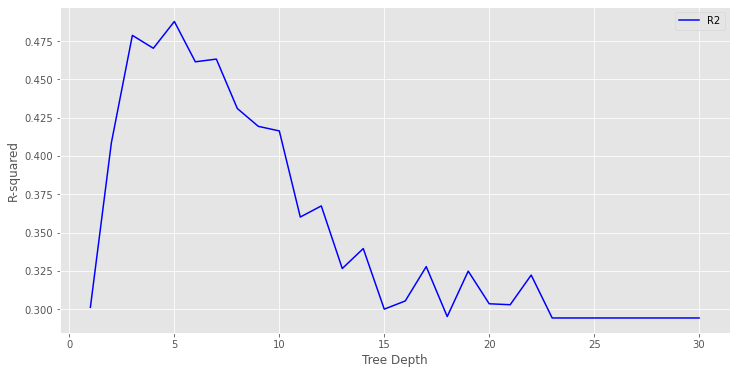

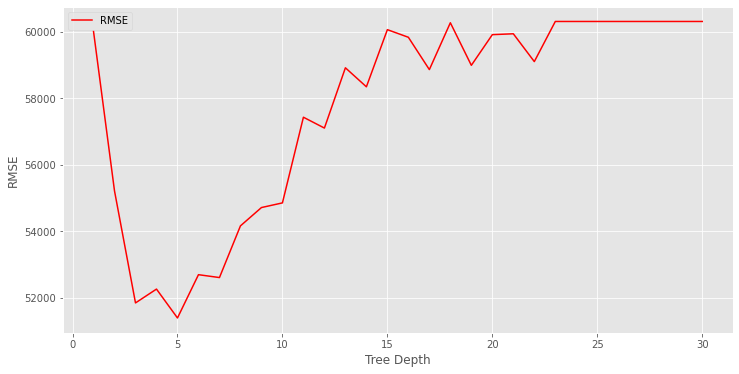

In [20]:
# Your code here # Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, 
                                      random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

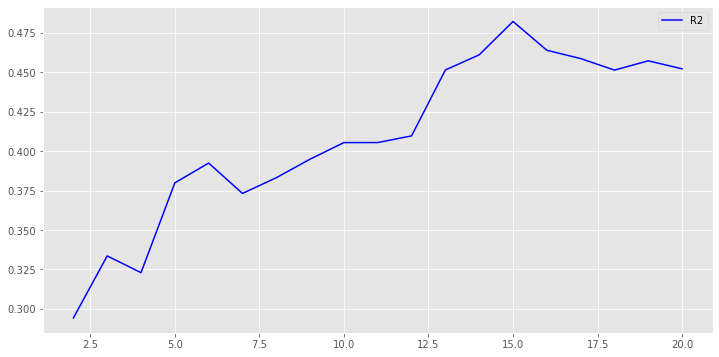

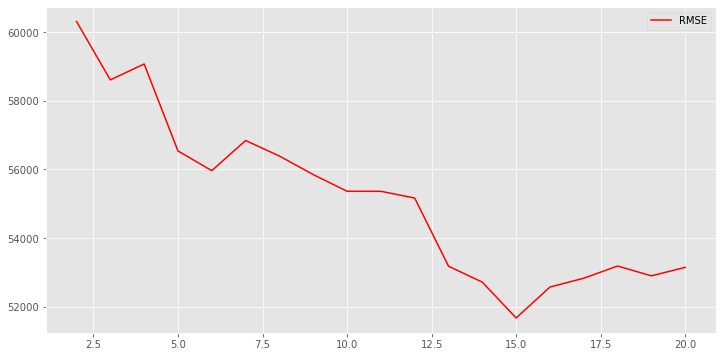

In [21]:
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(2, 21)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split),
                                      random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, mse_results, 'r', label='RMSE')
plt.legend()
plt.show()

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [22]:
regressor = DecisionTreeRegressor(min_samples_split=15, max_depth=5, random_state=45)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.4841259600781218,
 51565.78842479912,
 DecisionTreeRegressor(max_depth=5, min_samples_split=15, random_state=45))

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 
- Or - try different model types! <<

#### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

score = performance(y_test, y_pred_lr)
score[0], score[1]

(0.5380603557695889, 48795.80008129881)

#### Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf = RandomForestRegressor(max_depth=7, min_samples_split=4, random_state=123)

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

score = performance(y_test, y_pred_rf)
score[0], score[1]

(0.5681432924662088, 47180.18725495614)

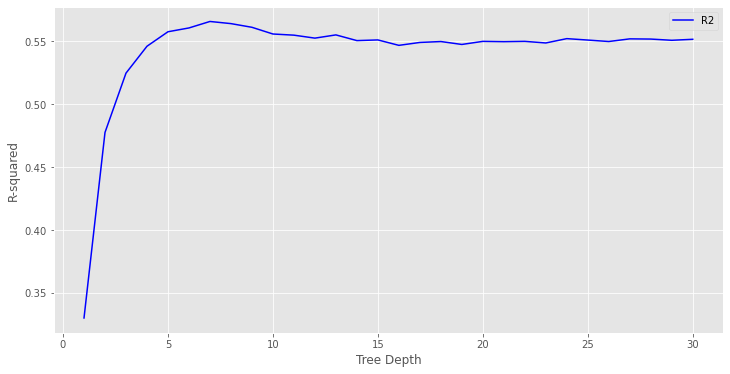

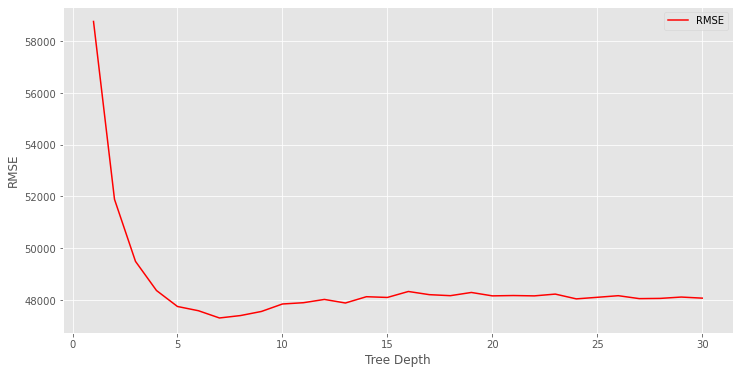

In [26]:
# Your code here # Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = RandomForestRegressor(max_depth=max_depth, 
                                      random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

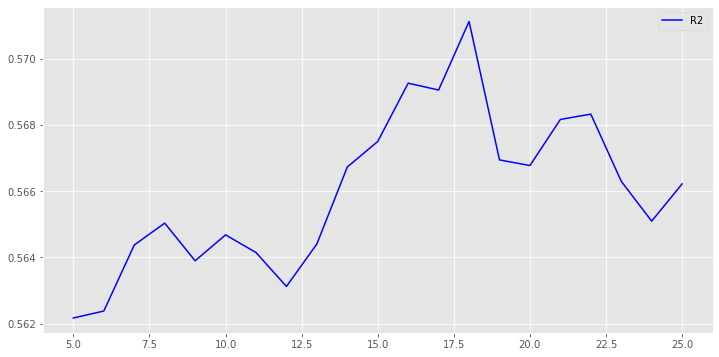

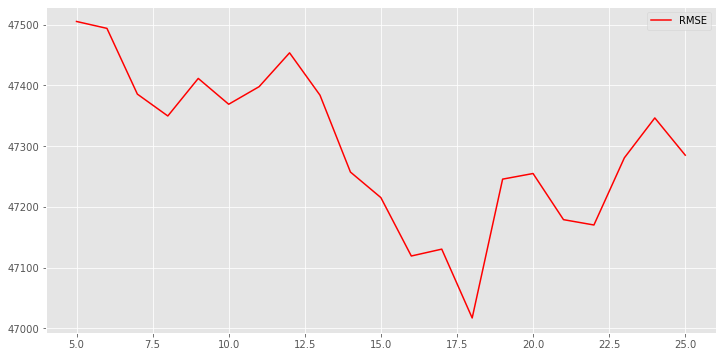

In [27]:
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(5, 26)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = RandomForestRegressor(min_samples_split=int(min_samples_split),
                                      random_state=123)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, mse_results, 'r', label='RMSE')
plt.legend()
plt.show()

In [28]:
rf_final = RandomForestRegressor(max_depth=7, min_samples_split=18, random_state=123)

rf_final.fit(x_train, y_train)
y_pred_final = rf_final.predict(x_test)

score = performance(y_test, y_pred_final)
score[0], score[1]

(0.5657619017727418, 47310.09144911988)

Not great - but not terrible. Let's deploy it

#### Pickle the Model

In [29]:
import pickle

pickle.dump(rf_final, open('models/ames-model.sav', 'wb'))

In [30]:
loaded_model = pickle.load(open('models/ames-model.sav', 'rb'))

In [31]:
loaded_model

RandomForestRegressor(max_depth=7, min_samples_split=18, random_state=123)

#### Testing for Streamlit

How do we structure our data to predict on new input rows?

In [38]:
x_train.columns

Index(['LotArea', '1stFlrSF', 'GrLivArea'], dtype='object')

In [33]:
# Create an empty dataframe to capture inputs
test_data = pd.DataFrame(columns = x_train.columns)

In [35]:
# Add in an example random new row to that test data
test_data = test_data.append({'LotArea': 1300, '1stFlrSF' : 350, 'GrLivArea': 350}, 
                             ignore_index=True)

In [36]:
# Sanity check
test_data

,LotArea,1stFlrSF,GrLivArea
0,1300,350,350


In [37]:
# Test our predictions
loaded_model.predict(test_data)

array([67098.33725499])